Course: Alogrithms in bioinformatics 24/10-2017

#1 Differential expression 

In [1]:
from scipy import stats
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd


def generate_expression_data(n_analytes=100, n_samples=2, n_replicates=3, p_regulated=0.2, mean_offset=3.0, var=0.2, diff_var=2.0):
    # Here we follow a convension, The first sample is the reference i.e. have all label 1
    labels = npr.binomial(1, p_regulated, (n_analytes,n_samples-1))
    template = np.hstack((np.zeros((n_analytes,1)),labels))
    
    # We expand the template labels into several replicates
    regulated = np.repeat(template,n_replicates, axis=1)
    
    # If the reading is regulated, offset it with a random offset sampled from the normal distribution 
    offset = regulated*npr.normal(0,diff_var,(n_analytes,1))
    
    # Model a differentexpression level for the different analytes
    expr_level = np.ones((n_analytes,n_samples*n_replicates))*npr.normal(mean_offset,mean_offset,(n_analytes,1))
    
    # add noice for each measurement
    expression = npr.normal(offset+expr_level,var,(n_analytes,n_replicates*n_samples))
    expression = 2**expression
    
    analyte_names = ["a"+str(i+1) for i in range(n_analytes)]
    sample_names = ["s"+str(i+1)+'_'+str(j+1) for i in range(n_samples) for j in range(n_replicates)]
    
    # Create a dataframe for expression values
    expr_df = pd.DataFrame(expression,columns=sample_names,index=analyte_names)
    expr_df.loc["Sample",:] = [i+1 for i in range(n_samples) for j in range(n_replicates)]
    
    # Create a dataframe with answers if the reading was modeled as differential or not
    label_df = pd.DataFrame(template,columns=[i+1 for i in range(n_samples)],index=analyte_names)
                
    return expr_df,label_df

9999 10000


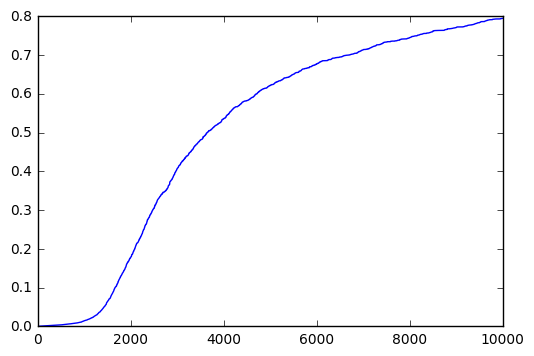

In [2]:
#Calcuating q-values based on p-values
def calc_q(pvalues):
    #pvalues in ordered array
    lambdaa = np.arange(0.01, 0.96, 0.01)
    m = len(pvalues)
    pi_est = [np.shape(np.where(pvalues > l))[1] / (m * (1 -l)) for l in lambdaa]
    start = int(len(pi_est) * 0.75)
    sub = pi_est[start:]
    pi0 = np.mean(sub)
    
    lFdr = []
    for t in sorted(pvalues):
        lFdr.append((pi0 * m * t) / (len(lFdr) + 1))

    lQ = []
    for i in range(1, len(lFdr)):
        fdr_ = lFdr[len(lFdr)-i:]
        q = min(fdr_)
        lQ.insert(0,q)
    print len(lQ), len(pvalues)
    return lQ

df, df_labels = generate_expression_data(n_analytes=10000, n_samples=2, n_replicates=3, p_regulated=0.2)

pvalues = np.sort(stats.ttest_ind(df.iloc[:,0:3], df.iloc[:,3:], axis=1)[1], kind='mergesort')
pvalues = pvalues[:-1]
q_values = calc_q(pvalues)
plt.plot(q_values)
plt.show()


## #5 - Genes under threshold

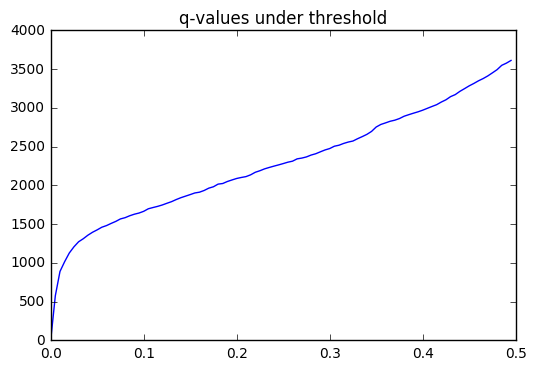

In [3]:
lDiff = []
for thres in np.arange(0, 0.5, 0.005):
    diff = len([q for q in q_values if q <= thres])
    lDiff.append(diff)
plt.plot(np.arange(0, 0.5, 0.005), lDiff)
plt.title('q-values under threshold')
plt.show()


## 6 - Plot the difference between q-values and the actual fraction of null statistics

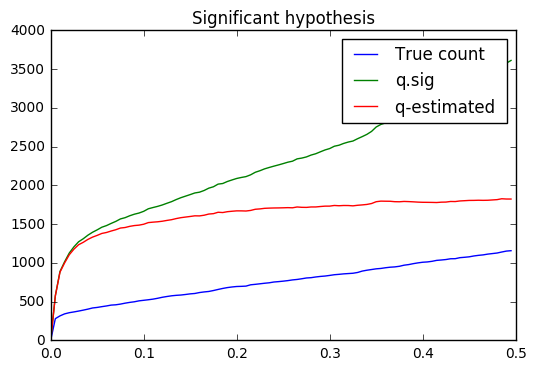

In [4]:

lRows = df_labels.iloc[:,1] == 1
lP = pvalues[lRows]
lDiff_c2 = []
for t in np.arange(0, 0.5, 0.005):
    lDiff_c = [p for p in lP if p <= t]
    lDiff_c2.append(len(lDiff_c))

lQEst_count = []
x = np.arange(0, 0.5, 0.005)
for i in range(len(lDiff_c2)):
    count = lDiff[i]
    x_c = x[i]
    est_count = count - count * x_c
    lQEst_count.append(est_count)
    
true_counts = plt.plot(x, lDiff_c2, label="True count")
q_counts = plt.plot(x, lDiff, label="q.sig")
q_est_true = plt.plot(x, lQEst_count, label="q-estimated ")
plt.legend()
plt.title("Significant hypothesis")
plt.show()
    

## Exercise #2 Weighloss blood plasma set

/usr/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
/usr/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in less
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
/usr/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:1749: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


227 228
227 228


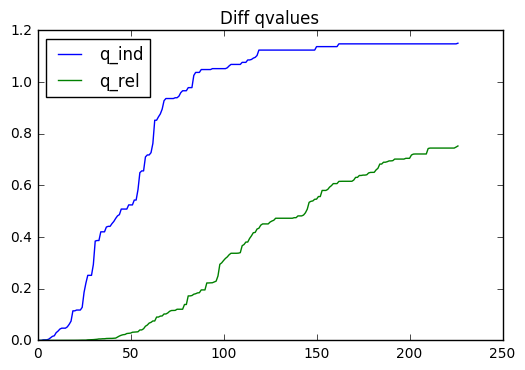

In [5]:
df = pd.read_excel("MSB-12-901-s009.xlsx", skiprows=range(6)+range(15,18), parse_cols=[0]+range(3,318), header=0, index_col=0)


lcol_7 = [t for t in df.columns if '_7' in t]
lcol_1 = [t for t in df.columns if t.endswith('_1')]

#df_t7 = df_full.dropna()
df_1_7 = df.loc[:,lcol_1].join(df.loc[:,lcol_7])
df_1_7

#Extract the patients which have both the datapoints for timepoint 1 and 7
lC_1 = [t.split('_')[1] for t in lcol_1]
lC_7 = [t.split('_')[1] for t in lcol_7]
lFull_set = list(set(lC_1) & set(lC_7))
lcol_1 = [t for t in lcol_1 if t.split('_')[1] in lFull_set]
lcol_7 = [t for t in lcol_7 if t.split('_')[1] in lFull_set]

# Calculate p-values based on previous assigment
res_1_7_ind = stats.ttest_ind(df.loc[:,lcol_1], df.loc[:,lcol_7], axis=1, nan_policy='propagate')
res_1_7_rel = stats.ttest_rel(df.loc[:,lcol_1], df.loc[:,lcol_7], axis=1, nan_policy='propagate')

#Filter out nan-values
pvalues_ind = res_1_7_ind.pvalue[~np.isnan(res_1_7_ind.pvalue)]
pvalues_rel = res_1_7_rel.pvalue[~np.isnan(res_1_7_rel.pvalue)]

qvalues_ind = calc_q(pvalues_ind)
qvalues_rel = calc_q(pvalues_rel)


plt.plot(qvalues_ind, label="q_ind")
plt.plot(qvalues_rel, label="q_rel")
plt.legend(loc='best')
plt.title("Diff qvalues")
plt.show()


In [6]:
#Total amount of differentially expresed analytes between timepoint 1 and 7
#ind
print 'D/E analytes ind:', len([q for q in qvalues_ind if q <= 0.05])
print 'D/E analytes rel:', len([q for q in qvalues_rel if q <= 0.05])
#rel


D/E analytes ind: 16
D/E analytes rel: 58
